# Reddit Comments Analysis — VADER Sentiment + Theme Frequency (Updated)

Updates included:
- Robust `area` mapping from `subreddit` (prevents empty dataframe)
- Optional renaming to **Bijlmer/Zuidoost** to match earlier visuals
- Sentiment labels standardized to lowercase (`negative/neutral/positive`)
- Theme frequency plot kept ("Frequency of themes in comments")
- Grouped bar chart kept ("Sentiment of Comments by Area")


In [24]:
import requests
import pandas as pd
import time
from tqdm import tqdm

"""
Reddit scraper for De Pijp vs Bijlmer/Zuidoost discussion

This notebook:
- Scrapes posts from selected subreddits (r/Amsterdam, r/StudyInTheNetherlands, r/thenetherlands)
- Keeps only posts that are clearly about **De Pijp** or **Bijlmer/Zuidoost**
- Downloads all comments for those posts
- Also scrapes a list of specific Reddit thread URLs you provided
- Outputs two CSVs:
    - posts_amsterdam_depijp_bijlmer_posts.csv
    - comments_amsterdam_depijp_bijlmer_comments.csv
"""

# --- Area keyword sets ---

DE_PIJP_KEYWORDS = [
    "de pijp",
    "depijp",
    "pijp",
    "amsterdam de pijp",
    "living in de pijp",
    "de pijp neighborhood",
    "de pijp neighbourhood",
]

BIJLMER_KEYWORDS = [
    "bijlmer",
    "bijlmermeer",
    "amsterdam bijlmer",
    "bijlmer arena",
    "bijlmer station",
    "zuidoost",
    "amsterdam zuidoost",
    "amsterdam zuid-oost",
    "amsterdam zuid oost",
    "amsterdam southeast",
    "amsterdam south east",
    "amsterdam se",
    "living in bijlmer",
    "living in zuidoost",
]

# Combined list used only for simple "contains" matching, but we still
# classify into De Pijp vs Bijlmer/Zuidoost explicitly.
AREA_KEYWORDS = DE_PIJP_KEYWORDS + BIJLMER_KEYWORDS

# --- Subreddits and specific threads ---

SUBREDDITS = [
    "Amsterdam",
    "StudyInTheNetherlands",
    "thenetherlands",
]

# Specific threads (URLs you shared)
THREAD_URLS = [
    "https://www.reddit.com/r/StudyInTheNetherlands/s/LpT8iO1RlT",
    "https://www.reddit.com/r/Amsterdam/s/UZzxXsBbDg",
    "https://www.reddit.com/r/Amsterdam/s/9SOjEhzpB7",
    "https://www.reddit.com/r/Amsterdam/s/ukE9esmDI4",
]

MAX_POSTS_PER_SUBREDDIT = 1000   # overall cap per subreddit
REQUEST_DELAY = 1.2              # seconds between HTTP requests


def classify_area_from_text(text: str) -> str:
    """
    Very simple rule-based classifier that tags a text as:
    - 'De Pijp'
    - 'Bijlmer/Zuidoost'
    - 'Other/Amsterdam'
    """
    t = (text or "").lower()

    for kw in DE_PIJP_KEYWORDS:
        if kw.lower() in t:
            return "De Pijp"

    for kw in BIJLMER_KEYWORDS:
        if kw.lower() in t:
            return "Bijlmer/Zuidoost"

    return "Other/Amsterdam"

### Reddit Scraper (Public JSON API)

This notebook collects:
1. Posts from one or more subreddits using `/r/<subreddit>/new.json`
2. All comments for each post using `/comments/<post_id>.json`

No OAuth or API keys are required.  
Only standard HTTP GET requests with a custom User-Agent.  

Outputs:
- `<subreddit>_posts.csv` for each subreddit
- `posts_ALL.csv` (merged)
- `comments_ALL.csv` (merged)

In [25]:
def _flatten_comment_tree(raw_comments, post_id=None, subreddit=None, area=None):
    """
    Turn Reddit's nested comment structure into a flat list of dicts.
    Each comment row includes:
    - post_id
    - subreddit
    - comment_id
    - author
    - body
    - score
    - created_utc
    - parent_id
    - area  (propagated from the parent post)
    """
    comments = []

    def extract(children):
        for child in children:
            if child.get("kind") != "t1":  # "t1" = comment
                continue

            d = child.get("data", {})

            comments.append({
                "post_id": post_id,
                "subreddit": subreddit or d.get("subreddit"),
                "comment_id": d.get("id"),
                "author": d.get("author"),
                "body": d.get("body"),
                "score": d.get("score"),
                "created_utc": d.get("created_utc"),
                "parent_id": d.get("parent_id"),
                "area": area,
            })

            replies = d.get("replies")
            if isinstance(replies, dict):
                extract(replies.get("data", {}).get("children", []))

    extract(raw_comments)
    return comments


def scrape_comments_for_post(post_id, subreddit=None, area=None):
    """
    Scrapes all comments for a Reddit post using the public JSON endpoint:
      https://www.reddit.com/comments/<post_id>.json

    Returns a list of flattened comment dicts.
    """
    url = f"https://www.reddit.com/comments/{post_id}.json"
    headers = {"User-Agent": "Mozilla/5.0 (research script, contact u/your_username)"}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching comments for {post_id}: {e}")
        return []

    try:
        data = response.json()
    except Exception as e:
        print(f"Error parsing JSON for {post_id}: {e}")
        return []

    # data[1] is the comment listing
    try:
        comments_listing = data[1]["data"]["children"]
    except (IndexError, KeyError, TypeError):
        return []

    comments = _flatten_comment_tree(
        comments_listing,
        post_id=post_id,
        subreddit=subreddit,
        area=area,
    )
    return comments

### scrape_comments_for_post()

This function returns:
- All top-level comments
- All nested replies (via recursion)

It returns a flat list that can easily be converted into a DataFrame.


In [26]:
def scrape_subreddit_posts(subreddit: str, max_posts: int = 1000) -> pd.DataFrame:
    """
    Scrape up to `max_posts` from a subreddit's /new listing using the public JSON API:

        https://www.reddit.com/r/<subreddit>/new.json

    No OAuth needed, just a custom User-Agent.
    Returns a DataFrame with one row per post.
    """
    print(f"\nDownloading posts from r/{subreddit} ...")

    url = f"https://www.reddit.com/r/{subreddit}/new.json"
    headers = {"User-Agent": "Mozilla/5.0 (research script, contact u/your_username)"}

    posts = []
    after = None

    while len(posts) < max_posts:
        params = {
            "limit": 100,
        }
        if after:
            params["after"] = after

        try:
            resp = requests.get(url, headers=headers, params=params)
            resp.raise_for_status()
        except Exception as e:
            print(f"Error fetching posts from r/{subreddit}: {e}")
            break

        try:
            data = resp.json()
        except Exception as e:
            print(f"Error parsing JSON from r/{subreddit}: {e}")
            break

        children = data.get("data", {}).get("children", [])
        if not children:
            break

        for child in children:
            if child.get("kind") != "t3":  # "t3" = submission
                continue

            d = child.get("data", {})
            posts.append({
                "post_id": d.get("id"),
                "subreddit": d.get("subreddit"),
                "title": d.get("title"),
                "selftext": d.get("selftext"),
                "created_utc": d.get("created_utc"),
                "num_comments": d.get("num_comments"),
                "score": d.get("score"),
                "permalink": "https://www.reddit.com" + d.get("permalink", ""),
                "url": d.get("url"),
            })

            if len(posts) >= max_posts:
                break

        after = data.get("data", {}).get("after")
        if not after:
            break

        time.sleep(REQUEST_DELAY)

    df = pd.DataFrame(posts)
    print(f"Collected {len(df)} raw posts from r/{subreddit}.")
    return df

In [27]:
def scrape_thread_from_url(url: str):
    """
    Scrape a single Reddit thread (post + comments) from any normal/share URL.

    We just hit "<url>.json" and let Reddit handle redirects.
    Returns:
        post_row (dict) or None,
        comments (list of dict)
    """
    json_url = url.rstrip("/") + ".json"
    headers = {"User-Agent": "Mozilla/5.0 (research script, contact u/your_username)"}

    print(f"Fetching thread JSON: {json_url}")

    try:
        response = requests.get(json_url, headers=headers)
        response.raise_for_status()
    except Exception as e:
        print(f"Error fetching {json_url}: {e}")
        return None, []

    try:
        data = response.json()
    except Exception as e:
        print(f"Error parsing JSON for {json_url}: {e}")
        return None, []

    # data[0] is the post listing, data[1] the comments
    try:
        post_listing = data[0]["data"]["children"]
        if not post_listing:
            print("No post data found in thread JSON.")
            return None, []
        post_data = post_listing[0]["data"]
    except (IndexError, KeyError, TypeError):
        print("Unexpected JSON structure for post.")
        return None, []

    subreddit = post_data.get("subreddit")
    title = post_data.get("title") or ""
    selftext = post_data.get("selftext") or ""

    # Classify area based on post title + selftext
    text_all = f"{title} {selftext}"
    area = classify_area_from_text(text_all)

    post_row = {
        "post_id": post_data.get("id"),
        "subreddit": subreddit,
        "title": title,
        "selftext": selftext,
        "created_utc": post_data.get("created_utc"),
        "num_comments": post_data.get("num_comments"),
        "score": post_data.get("score"),
        "permalink": "https://www.reddit.com" + post_data.get("permalink", ""),
        "url": "https://www.reddit.com" + post_data.get("permalink", ""),
        "source": "direct_url",
        "area": area,
    }

    # Now get comments
    try:
        comments_listing = data[1]["data"]["children"]
    except (IndexError, KeyError, TypeError):
        comments_listing = []

    comments = _flatten_comment_tree(
        comments_listing,
        post_id=post_row["post_id"],
        subreddit=subreddit,
        area=area,
    )
    return post_row, comments

### scrape_subreddit_posts()

This function:
- Uses `/new.json`
- Paginates with `after`
- Extracts basic post fields
- Saves a CSV per subreddit
- Returns a DataFrame


In [28]:
all_posts_dfs = []
all_comments_list = []

# --- 5A. Subreddit scraping with area filter ---

for subreddit in SUBREDDITS:
    print(f"\n=== Scraping posts from r/{subreddit} ===")
    
    df_posts_raw = scrape_subreddit_posts(
        subreddit=subreddit,
        max_posts=MAX_POSTS_PER_SUBREDDIT,
    )

    if df_posts_raw is None or df_posts_raw.empty:
        print(f"No posts found in r/{subreddit}.")
        continue

    # Combine title + selftext for area classification
    df_posts_raw["text_all"] = (
        df_posts_raw["title"].fillna("") + " " + df_posts_raw["selftext"].fillna("")
    )
    df_posts_raw["area"] = df_posts_raw["text_all"].apply(classify_area_from_text)

    # Keep only De Pijp / Bijlmer/Zuidoost posts
    df_posts = df_posts_raw[
        df_posts_raw["area"].isin(["De Pijp", "Bijlmer/Zuidoost"])
    ].copy()

    if df_posts.empty:
        print(f"No De Pijp/Bijlmer posts found in r/{subreddit}.")
        continue

    # Tag where they came from
    df_posts["source"] = f"subreddit_{subreddit}"
    all_posts_dfs.append(df_posts)

    print(f"Downloading comments for {len(df_posts)} posts in r/{subreddit} ...")
    for _, row in tqdm(df_posts.iterrows(), total=len(df_posts)):
        post_id = row["post_id"]
        area = row["area"]
        sub = row["subreddit"]

        comments = scrape_comments_for_post(post_id, subreddit=sub, area=area)
        all_comments_list.extend(comments)
        time.sleep(REQUEST_DELAY)

# --- 5B. Direct URLs (your specific threads) ---

print("\n=== Scraping specific threads from provided URLs ===")

for url in THREAD_URLS:
    print(f"→ {url}")
    post_row, comments = scrape_thread_from_url(url)
    if post_row is None:
        continue

    all_posts_dfs.append(pd.DataFrame([post_row]))
    all_comments_list.extend(comments)
    time.sleep(REQUEST_DELAY)

# --- 5C. Combine + save ---

if len(all_posts_dfs) > 0:
    df_posts_full = pd.concat(all_posts_dfs, ignore_index=True)
else:
    df_posts_full = pd.DataFrame()
    print("Warning: No posts were collected.")

df_comments_full = pd.DataFrame(all_comments_list)

# Add a lowercase body column to comments for easier text processing later
if not df_comments_full.empty:
    df_comments_full["body_lower"] = df_comments_full["body"].fillna("").str.lower()

# Save the data
posts_out = "posts_amsterdam_depijp_bijlmer_posts.csv"
comments_out = "comments_amsterdam_depijp_bijlmer_comments.csv"

df_posts_full.to_csv(posts_out, index=False)
df_comments_full.to_csv(comments_out, index=False)

print("\nDONE!")
print(f"Saved posts → {posts_out}  (rows: {len(df_posts_full)})")
print(f"Saved comments → {comments_out}  (rows: {len(df_comments_full)})")


=== Scraping posts from r/Amsterdam ===

Collected 999 raw posts from r/Amsterdam.


100%|██████████| 16/16 [00:28<00:00,  1.81s/it]



=== Scraping posts from r/StudyInTheNetherlands ===

Collected 1000 raw posts from r/StudyInTheNetherlands.


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]



=== Scraping posts from r/thenetherlands ===

Collected 1000 raw posts from r/thenetherlands.


100%|██████████| 2/2 [00:03<00:00,  1.68s/it]



=== Scraping specific threads from provided URLs ===
→ https://www.reddit.com/r/StudyInTheNetherlands/s/LpT8iO1RlT
Fetching thread JSON: https://www.reddit.com/r/StudyInTheNetherlands/s/LpT8iO1RlT.json
Error parsing JSON for https://www.reddit.com/r/StudyInTheNetherlands/s/LpT8iO1RlT.json: Expecting value: line 2 column 5 (char 5)
→ https://www.reddit.com/r/Amsterdam/s/UZzxXsBbDg
Fetching thread JSON: https://www.reddit.com/r/Amsterdam/s/UZzxXsBbDg.json
Error parsing JSON for https://www.reddit.com/r/Amsterdam/s/UZzxXsBbDg.json: Expecting value: line 2 column 5 (char 5)
→ https://www.reddit.com/r/Amsterdam/s/9SOjEhzpB7
Fetching thread JSON: https://www.reddit.com/r/Amsterdam/s/9SOjEhzpB7.json
Error parsing JSON for https://www.reddit.com/r/Amsterdam/s/9SOjEhzpB7.json: Expecting value: line 2 column 5 (char 5)
→ https://www.reddit.com/r/Amsterdam/s/ukE9esmDI4
Fetching thread JSON: https://www.reddit.com/r/Amsterdam/s/ukE9esmDI4.json
Error parsing JSON for https://www.reddit.com/r/Amste

### Final Output

This notebook saves:
- posts_ALL.csv
- comments_ALL.csv

These contain all posts and comments collected from the specified subreddits.

## Graphs


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [30]:
# Load dataset
df = pd.read_csv("comments_amsterdam_depijp_bijlmer_comments.csv")

# Ensure text column is string
df["body"] = df["body"].fillna("").astype(str)


In [31]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["body"].apply(get_sentiment)


In [32]:
theme_keywords = {
    "Amenities": [
        "shop", "shops", "store", "stores", "cafe", "cafes",
        "restaurant", "restaurants", "amenity", "amenities", "supermarket"
    ],

    "Cleanliness": [
        "dirty", "clean", "trash", "garbage", "waste",
        "litter", "rubbish", "filthy"
    ],

    "Culture": [
        "culture", "cultural", "art", "arts", "music",
        "community", "events", "museum"
    ],

    "Development": [
        "development", "developing", "construction", "building",
        "renovation", "project", "infrastructure"
    ],

    "Gentrification": [
        "gentrification", "gentrified", "tourist", "tourists",
        "expensive", "prices", "wealthy"
    ],

    "Homelessness & Drugs": [
        "homeless", "homelessness", "drugs", "drug", "addict",
        "addiction", "junkie", "dealers"
    ],

    "Housing": [
        "rent", "rents", "housing", "apartment", "apartments",
        "home", "homes", "flat", "flats"
    ],

    "Institutions": [
        "school", "schools", "municipality", "government",
        "council", "authorities", "policy"
    ],

    "Mobility": [
        "bike", "bikes", "biking", "cyclist", "tram",
        "metro", "bus", "traffic", "transport", "transportation"
    ],

    "Nightlife": [
        "bar", "bars", "club", "clubs", "party",
        "parties", "nightlife", "drinking"
    ],

    "Noise": [
        "noise", "noisy", "loud", "sound", "disturbance"
    ],

    "Parking": [
        "parking", "parked", "car", "cars", "vehicles"
    ],

    "Public Space": [
        "park", "parks", "street", "streets",
        "square", "squares", "public space"
    ],

    "Safety": [
        "safe", "unsafe", "safety", "crime",
        "criminal", "police", "violence"
    ],

    "Youth Behavior": [
        "youth", "young", "teen", "teens",
        "teenagers", "kids", "children"
    ]
}

def assign_theme(text):
    if not isinstance(text, str):
        return "Other"

    text = text.lower()

    for theme, words in theme_keywords.items():
        if any(word in text for word in words):
            return theme

    return "Other"


df["theme"] = df["body"].apply(assign_theme)


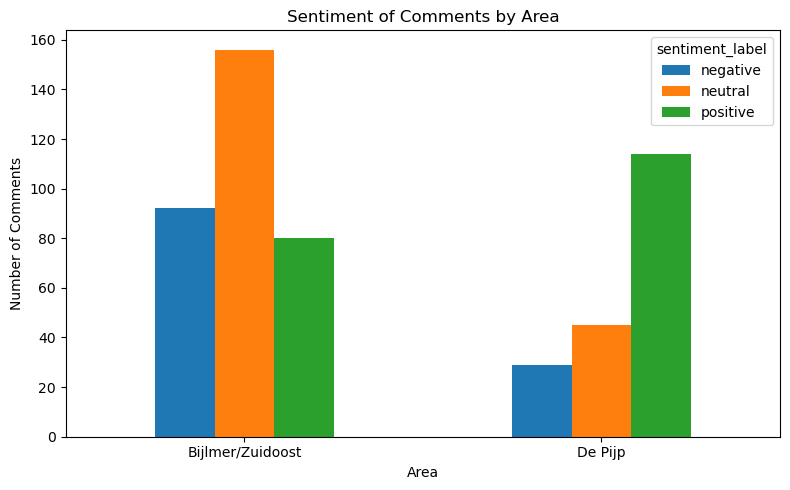

In [33]:
#Sentiment by Area (De Pijp vs Bijlmer/Zuidoost)
sentiment_area = (
    df.groupby(["area", "sentiment_label"])
      .size()
      .unstack(fill_value=0)
)

sentiment_area.plot(
    kind="bar",
    figsize=(8,5),
    title="Sentiment of Comments by Area"
)

plt.xlabel("Area")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### INTERPRETATION
The sentiment distribution shows a clear contrast between the two neighbourhoods. Comments about Bijlmer/Zuidoost are largely neutral, with a notable proportion of negative sentiment, suggesting more critical or problem-focused discourse. In contrast, De Pijp is predominantly discussed in positive terms, with relatively few negative comments. Overall, this indicates a more favourable perception of De Pijp compared to Bijlmer/Zuidoost, reflecting differing narratives or experiences associated with each area rather than objective conditions alone.

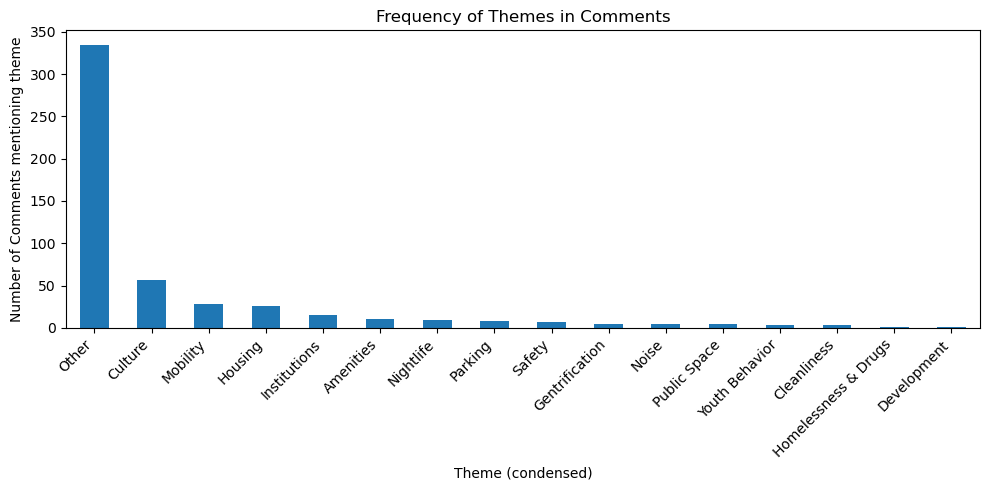

In [34]:
#Frequency of Themes (Overall)
theme_counts = df["theme"].value_counts()

theme_counts.plot(
    kind="bar",
    figsize=(10,5),
    title="Frequency of Themes in Comments"
)

plt.xlabel("Theme (condensed)")
plt.ylabel("Number of Comments mentioning theme")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### INTERPRETATION
The frequency distribution shows that a large proportion of comments fall under the category “Other,” indicating that many discussions do not directly align with the predefined themes. Among the specified themes, culture and mobility are the most frequently mentioned, followed by housing and institutions. Themes such as safety, nightlife, and amenities appear less often, while issues like homelessness and drugs, cleanliness, and development are rarely discussed. This suggests that public discourse is concentrated around cultural and mobility-related aspects, with more structural or social concerns receiving comparatively limited attention.

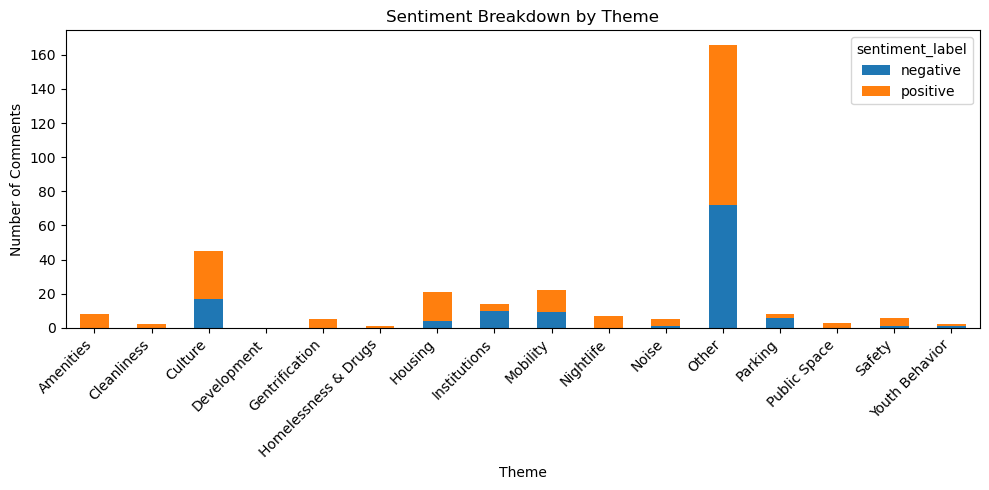

In [35]:
#Sentiment Breakdown by Theme
theme_sentiment = (
    df.groupby(["theme", "sentiment_label"])
      .size()
      .unstack(fill_value=0)
)

theme_sentiment[["negative", "positive"]].plot(
    kind="bar",
    stacked=True,
    figsize=(10,5),
    title="Sentiment Breakdown by Theme"
)

plt.xlabel("Theme")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### INTERPRETATION
The sentiment breakdown by theme shows that most themes contain a mix of positive and negative comments, though positive sentiment generally dominates. Cultural and mobility-related themes attract relatively high levels of positive sentiment, suggesting favourable perceptions in these areas. In contrast, themes such as housing, institutions, and safety display a more balanced or slightly negative sentiment, indicating areas of concern. The “Other” category contains the highest volume of both positive and negative comments, reflecting the diversity of topics not captured by the predefined themes.

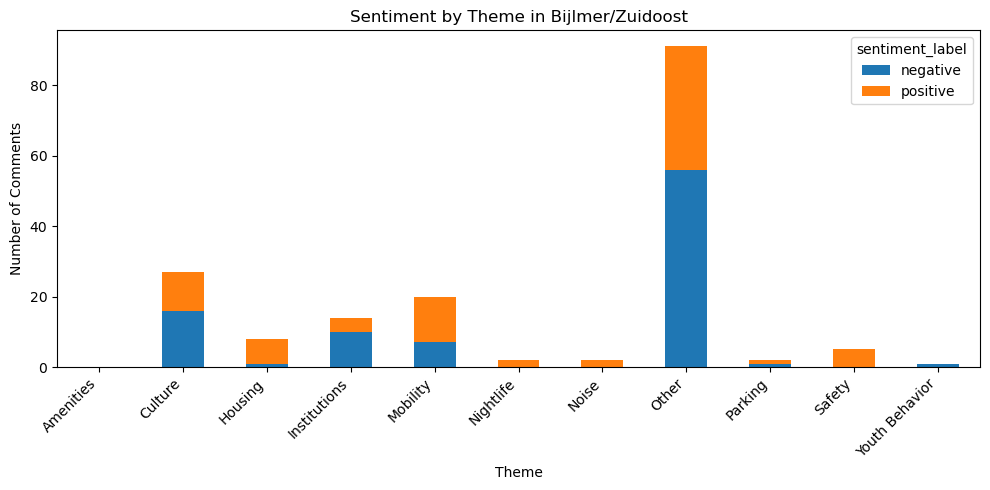

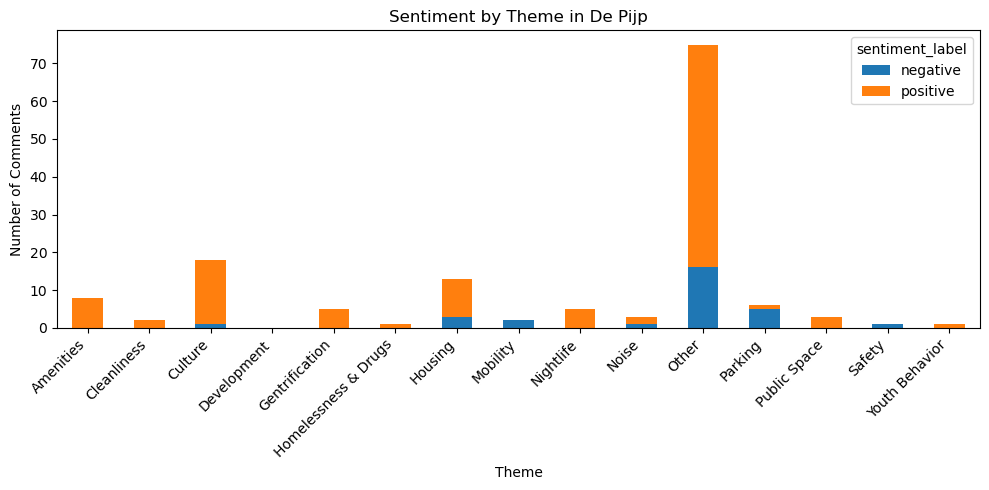

In [36]:
#Theme + Sentiment per Neighbourhood
for area in df["area"].unique():
    subset = df[df["area"] == area]

    area_theme_sentiment = (
        subset.groupby(["theme", "sentiment_label"])
              .size()
              .unstack(fill_value=0)
    )

    area_theme_sentiment[["negative", "positive"]].plot(
        kind="bar",
        stacked=True,
        figsize=(10,5),
        title=f"Sentiment by Theme in {area}"
    )

    plt.xlabel("Theme")
    plt.ylabel("Number of Comments")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### INTERPRETATION BIJLMER
In Bijlmer/Zuidoost, sentiment varies notably by theme. Cultural and mobility-related comments show a mix of positive and negative sentiment, though negative views are slightly more prominent. Themes such as housing and institutions also attract criticism, indicating ongoing concerns in these areas. The “Other” category dominates both positive and negative sentiment, suggesting that many discussions fall outside the predefined themes. Overall, discourse in Bijlmer/Zuidoost appears more critical than favourable across most themes.

### INTERPRETATION DE PIJP
In De Pijp, sentiment across themes is predominantly positive. Cultural, housing, amenities, and nightlife-related comments show strong positive sentiment with relatively few negative responses. Negative sentiment is limited and appears mainly in themes such as mobility, parking, and safety. As with Bijlmer/Zuidoost, the “Other” category accounts for a large share of comments, but in De Pijp it is more positively skewed. Overall, discourse around De Pijp reflects a generally favourable perception across most urban themes.